# 权重衰减
在多项式函数的拟合过程中，我们可以通过调整拟合多项式的阶数来限制模型的容量，实际上，限制特征的数量是缓解过拟合的一种常用技术。然而，简单地丢弃特征对这项工作来说可能过于生硬。仅仅通过简单的限制特征数量（在多项式回归中体现为限制阶数），可能仍然使模型在过简单和过复杂中徘徊，我们需要一个更细粒度的工具来调整函数的复杂性，使其达到一个合适的平衡位置。

## 范数与权重衰减
在训练参数化机器学习模型时，权重衰减（weight decay）是最广泛使用的正则化的技术之一，它通常也被称为$L_2$正则化。
在之前的线性回归中，我们的损失由下式计算得出：
$$
L(\mathbf{w},b)=\frac{1}{n}\sum_{i=1}^{n}\frac{1}{2}(\mathbf{w}^\top\mathbf{x}^{(i)}+b-y^{(i)})^2
$$
而我们想让权重函数尽可能地简单，就通过正则化常数$\lambda$来描述这个权衡，这是一个非负超参数，我们使用验证数据拟合：
$$
L(\mathbf{w},b)+\frac{\lambda}{2}||\mathbf{w}||^2
$$
对于$\lambda=0$，我们恢复了原来的损失函数。对于$\lambda>0$，我们限制$||\mathbf{w}||^2$的大小。 
与特征选择相比，权重衰减为我们提供了一种连续的机制来调整函数的复杂度。较小的$\lambda$值对应较少约束的$\mathbf{w}$，而较大的$\lambda$值对$\mathbf{w}$的约束更大。
是否对相应的偏置$b^2$进行惩罚在不同的实践中会有所不同，在神经网络的不同层中也会有所不同。通常，网络输出层的偏置项不会被正则化。

## 高维线性回归
我们通过一个简单的例子来演示权重衰减。


In [1]:
%matplotlib inline
import torch
from torch import nn
import sys
sys.path.append("..")
import MyTool

首先，我们像以前一样生成一些数据，生成公式如下：
$$
y=0.05+\sum_{i=1}^d0.01x_i+\epsilon\,\,\, \mathrm{where}\,\,\epsilon～\mathcal{N} (0,0.1^2)
$$
我们选择标签是关于输入的线性函数。标签同时被均值为0，标准差为0.01高斯噪声破坏。为了使过拟合的效果更加明显，我们可以将问题的维数增加到d=200，并使用一个只包含20个样本的小训练集。

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = MyTool.synthetic_data(true_w, true_b, n_train)
train_iter = MyTool.load_array(train_data, batch_size)
test_data = MyTool.synthetic_data(true_w, true_b, n_test)
test_iter = MyTool.load_array(test_data, batch_size, is_train=False)

## 从零开始实现
下面我们将从头开始实现权重衰减，只需将$L_2$的平方惩罚添加到原始目标函数中。
### 初始化模型参数
首先，我们将定义一个函数来随机初始化模型参数。

In [3]:
def init_params(): # 初始化模型参数
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True) # 权重
    b = torch.zeros(1, requires_grad=True) # 偏置
    return [w, b]

### 定义$L_2$范数惩罚
实现这一惩罚最方便的方法是对所有项求平方后并将它们求和。

In [4]:
def l2_penalty(w): # 定义L2范数惩罚
    return torch.sum(w.pow(2)) / 2

### 定义训练代码实现
下面的代码将模型拟合训练数据集，并在测试数据集上进行评估。线性网络和平方损失没有变化，唯一的变化是损失现在包括了惩罚项。

In [19]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: MyTool.linreg(X, w, b), MyTool.squared_loss
    num_epochs, lr = 100, 0.003
    animator = MyTool.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], ylim=[0.00001, 100], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            MyTool.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (MyTool.evaluate_loss(net, train_iter, loss),
                                     MyTool.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

### 忽略正则化直接训练
我们现在用lambd = 0禁用权重衰减后运行这个代码。注意，这里训练误差有了减少，但测试误差没有减少，这意味着出现了严重的过拟合。

w的L2范数是： 13.692438125610352


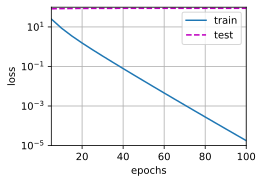

In [20]:
train(lambd=0)

### 使用权重衰减
下面，我们使用权重衰减来运行代码。注意，在这里训练误差增大，但测试误差减小。这正是我们期望从正则化中得到的效果。

w的L2范数是： 0.3660566210746765


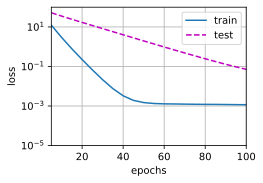

In [21]:
train(lambd=3)

## 简洁实现
由于权重衰减在神经网络优化中很常用，深度学习框架为了便于我们使用权重衰减，将权重衰减集成到优化算法中，以便与任何损失函数结合使用。此外，这种集成还有计算上的好处，允许在不增加任何额外的计算开销的情况下向算法中添加权重衰减。由于更新的权重衰减部分仅依赖于每个参数的当前值，因此优化器必须至少接触每个参数一次。
在下面的代码中，我们在实例化优化器时直接通过weight_decay指定weight decay超参数。默认情况下，PyTorch同时衰减权重和偏移。这里我们只为权重设置了weight_decay，所以偏置参数b不会衰减。

In [32]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = MyTool.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], ylim=[0.00001, 200],legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (MyTool.evaluate_loss(net, train_iter, loss),
                          MyTool.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

这些图看起来和我们从零开始实现权重衰减时的图相同。然而，它们运行得更快，更容易实现。对于更复杂的问题，这一好处将变得更加明显。

w的L2范数： 13.356010437011719


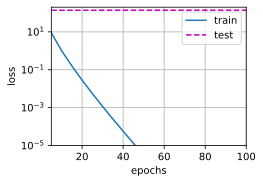

In [33]:
train_concise(0)

w的L2范数： 0.34482529759407043


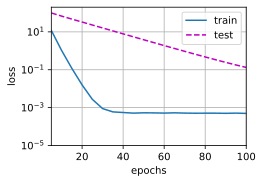

In [34]:
train_concise(3)